# Сентимент-анализ отзывов на товары

https://inclass.kaggle.com/c/product-reviews-sentiment-analysis-light

Классифицируйте отзывы по тональности

In [80]:
import re
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

Читаем данные

In [39]:
train = pd.read_csv("data/products_sentiment_train.tsv", sep='\t')
test = pd.read_csv("data/products_sentiment_test.tsv", sep='\t')

In [40]:
train.head()

,text,grade
0,"take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [41]:
test.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


Каков размер

In [42]:
print('Size of train:', train.shape[0])
print('Size of test:', test.shape[0])

Size of train: 2000
Size of test: 500


Сравним количество позитивных и негативных

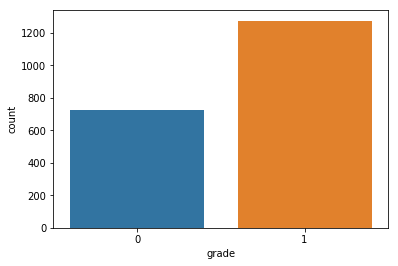

In [43]:
sb.countplot(x='grade', data=train)

Видим, что есть перекос в сторону позитивных отзывов

Создадим общий список отзывов

In [78]:
reviews = pd.concat([train, test], axis=0)

In [83]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(train['text'])
X_train_counts.shape

(2000, 3973)

Количество уникальных слов (фич)

In [82]:
quantity_of_features = len(vectorizer.get_feature_names())
print(quantity_of_features)

4488


Отделим "ответы" от текстов

In [79]:
y = train['grade']

Запустим простую регрессию

In [ ]:
log_reg = LogisticRegression()
pipeline = Pipeline([('vect', CountVectorizer()), 
                     ('clf', LogisticRegression())])
